In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from pymongo import MongoClient
import hashlib
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from dateutil.relativedelta import relativedelta
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Функция для обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

## Предсказание количества новых пользователей на реальных данных

###### Загрузим данные из MongoDB и сформируем датафрейм с новыми платящими пользователями помесячно - предсказывать будем ежемесячный приток:

In [3]:
client = MongoClient('***')
db = client['***']
collection = db['***']
collection2 = db['***']

pay = json_normalize(collection.find({'service': 'Payments', 'bill_time': {"$gte": "2016-12-01", "$lt": '2020-03-01'}},
                                    {'CLD':1, 'account_id':1, 'bill_time':1, 'charged_amount':1, '_id':0}))


portret = json_normalize(collection2.find({},
                                   {'created_at':1, 'phone_hash':1, '_id':0}))


pay = pay[pay['CLD'].str.contains("bonus|sandbox|slack")==False]
pay['bill_time'] = pd.to_datetime(pay['bill_time'])
pay['hash'] = pay['account_id'].apply(lambda x: hashlib.md5(x.encode('utf-8')).hexdigest())
pay['charged_amount'] = pay['charged_amount']*-1
pay = pay.merge(portret,left_on = 'hash', right_on = 'phone_hash', how = 'inner')
pay['created_at'] = pd.to_datetime(pay['created_at'], errors = 'coerce')
pay = pay[pay['created_at'].isnull()==False]
pay["months"] = pay['bill_time'].apply(lambda x: x.replace(day=1))
pay["months_created"] = pay['created_at'].apply(lambda x: x.replace(day=1))
pay['months'] = pay['months'].dt.date
pay['months_created'] = pay['months_created'].dt.date
pay = pay[pay['months'] == pay['months_created']]

In [4]:
pay_months = pay.groupby(['months']).agg({'hash':'nunique'})
pay_months.index = pd.to_datetime(pay_months.index)

In [5]:
# Домножу данные на некий коэффициент для их маскировки:
k = ***
pay_months['hash'] = np.round(pay_months['hash'] * k, 0)

In [6]:
# Получившийся датафрейм:
pay_months.tail(10)

,hash
months,
2019-05-01,2110.0
2019-06-01,2467.0
2019-07-01,2433.0
2019-08-01,2182.0
2019-09-01,2175.0
2019-10-01,2508.0
2019-11-01,3592.0
2019-12-01,2988.0
2020-01-01,3610.0


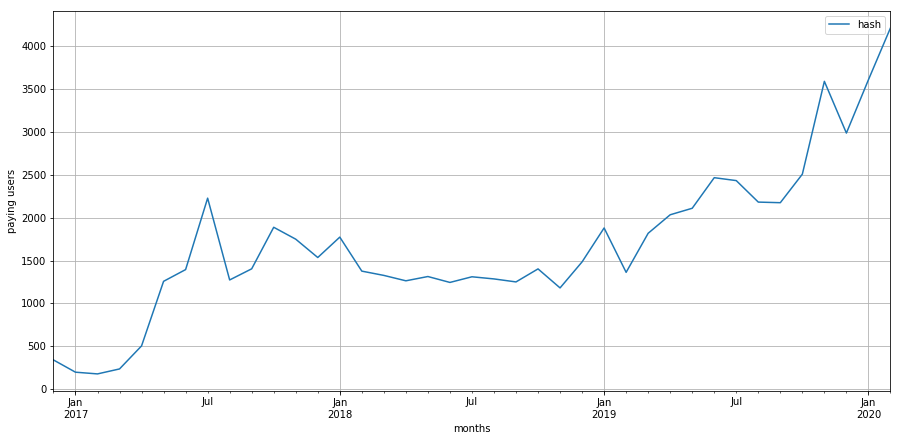

In [7]:
# Посмотрим на график временного ряда: он имеет явный выраженный положительный тренд с февраля 2019г -
# рост числа новых платящих пользователей.
plt.rcParams["figure.figsize"] = (15,7)
pay_months.plot()
plt.ylabel('paying users')
plt.grid()
plt.show()

###### Декомпозиция и преобразование временного ряда:

Критерий Дики-Фуллера: p=0.9701952268390077


<Figure size 1080x720 with 0 Axes>

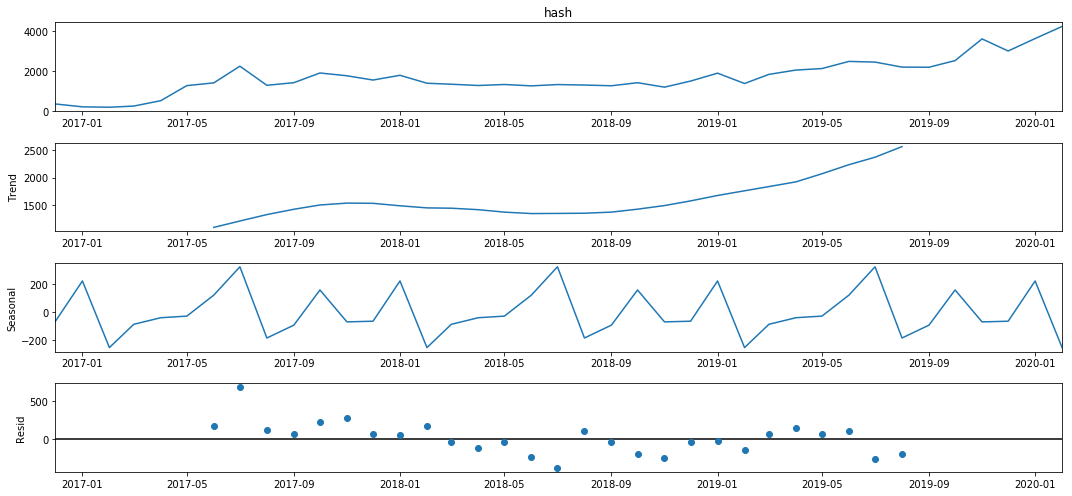

In [8]:
# Сделаем декомпозицию ряда - видно, что имеется тренд и годовая сезонность, т.е. сезонность равна 12.
# Также Критерий Дики-Фуллера говорит нам, что ряд не стационарный, соответственно понадобятся преобразования.
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(pay_months['hash']).plot()
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(pay_months['hash'])[1]))
plt.show()

Оптимальный параметр преобразования Бокса-Кокса: 0.6525967086380041
Критерий Дики-Фуллера: p=0.7407159289220413


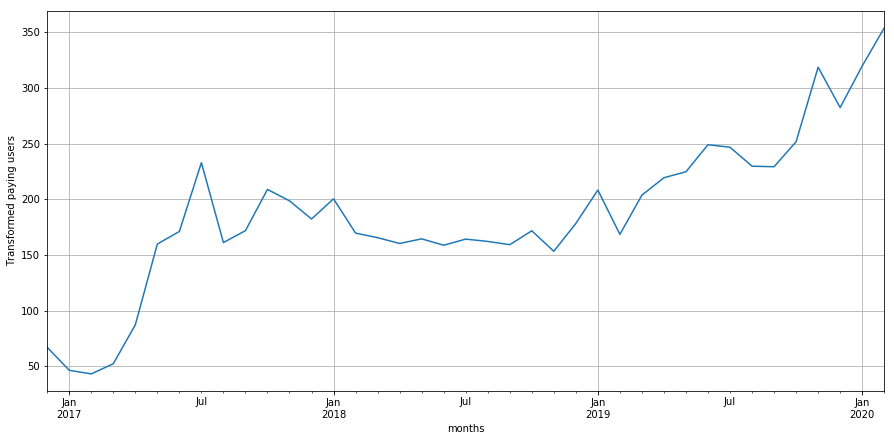

In [9]:
# Сначала сделаем преобразование Бокса-Кокса для стабилизации дисперсии, и получим коэффициент стабилизации lambda.
# Ситуация чуть улучшилась, p-value Дики-Фуллера уменьшился, но ряд всё еще не стационарен.
pay_months['hash_box'], lmbda = stats.boxcox(pay_months.hash)
plt.figure(figsize = (15,7))
pay_months['hash_box'].plot()
plt.ylabel('Transformed paying users')
plt.grid()
print("Оптимальный параметр преобразования Бокса-Кокса: {}".format(lmbda))
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(pay_months['hash_box'])[1]))
plt.show()

Критерий Дики-Фуллера: p=0.7811742488512599


<Figure size 1080x720 with 0 Axes>

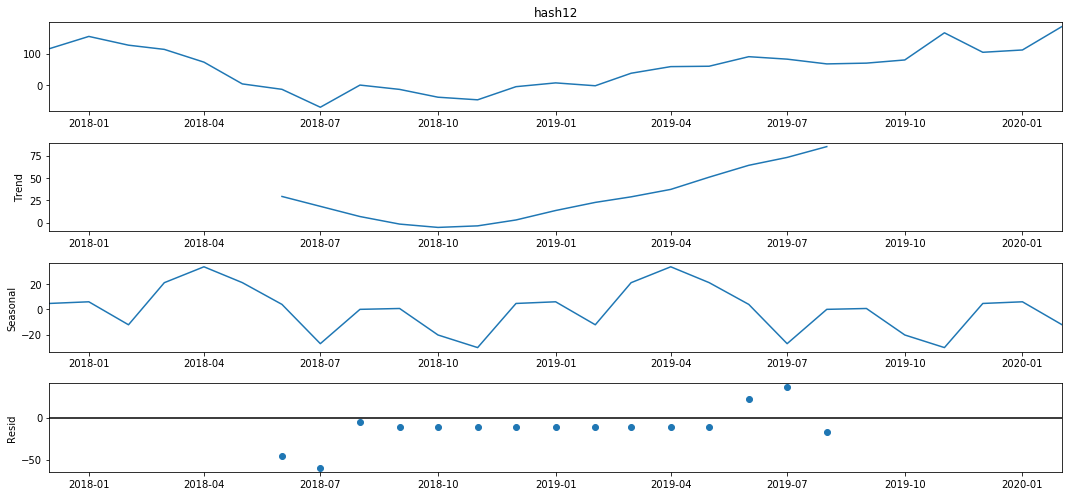

In [10]:
# Далее сделаем сезонное дифференцирование, ряд всё еще не стационарен.
pay_months['hash12'] = pay_months['hash_box'] - pay_months['hash_box'].shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(pay_months['hash12'][12:]).plot()
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(pay_months.hash12[12:])[1]))
plt.show()

Критерий Дики-Фуллера: p=0.017091196472653038


<Figure size 1080x720 with 0 Axes>

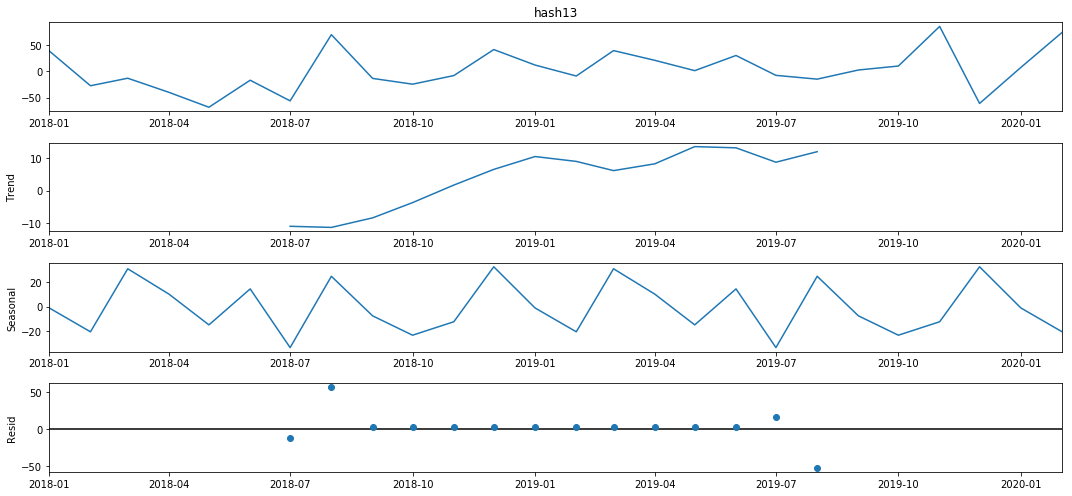

In [11]:
# Сделаем обычное дифференцирование. Теперь критерий Дики-Фуллера говорит, что ряд уже стационарен.
pay_months['hash13'] = pay_months['hash12'] - pay_months['hash12'].shift(1)
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(pay_months.hash13[13:]).plot()  
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(pay_months.hash13[13:])[1]))

###### Подбор параметров и обучение модели SARIMA:

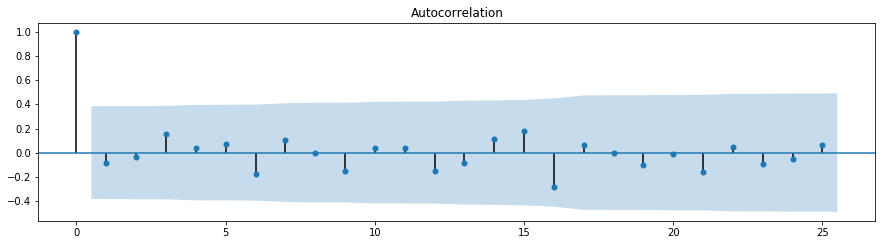

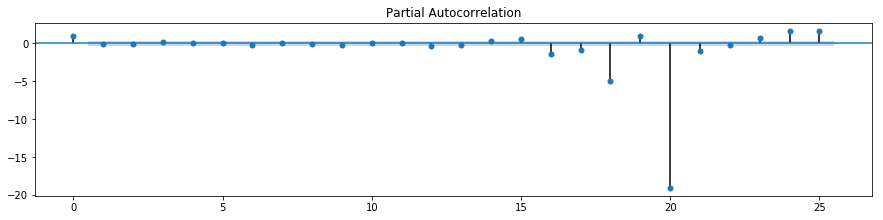

In [12]:
# Подберем первичные приближения по автокорреляционному и частично автокорреляционному графикам 
# для подбора оптимальных параметров модели SARIMA
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(pay_months.hash13[13:].values.squeeze(), lags=25, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(pay_months.hash13[13:].values.squeeze(), lags=25, ax=ax)
plt.show()

Начальные приближения: Q=0, q=0, P=2, p=0

In [13]:
ps = range(0, 1) 
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 1)

In [14]:
# Число всех сочетаний параметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

3

In [15]:
%%time
# Теперь подберем оптимальные параметры модели по критерию Акаике
results = []
best_aic = float("inf")

for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(pay_months.hash_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Wall time: 148 ms


In [16]:
# Оптимальные параметры:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
0,"(0, 0, 0, 0)",266.387892
1,"(0, 0, 1, 0)",267.070630
2,"(0, 0, 2, 0)",NaN


In [17]:
# Посмотрим на все параметры лучшей модели, и, например, 
# по критерию Льюнга-Бокса остатки неавтокоррелированные, что очень хорошо
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           hash_box   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -132.194
Date:                            Sun, 01 Mar 2020   AIC                            266.388
Time:                                    13:57:41   BIC                            267.646
Sample:                                12-01-2016   HQIC                           266.750
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1526.3245    455.502      3.351      0.001     633.556    2419.093
Ljung-Box (Q):                     

###### Качество остатков:

Критерий Стьюдента: p=0.7321190734393856
Критерий Дики-Фуллера: p=0.017091196472646904
Q-Критерий Льюнга-Бокса: p=0.8900313785482988


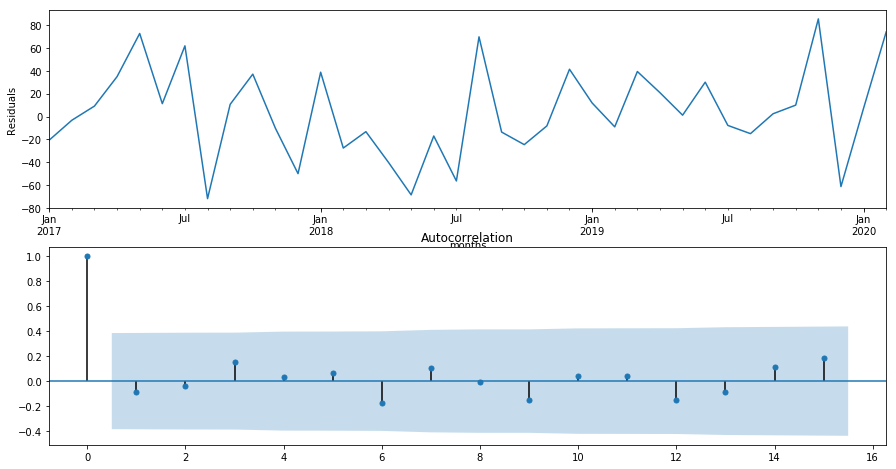

In [18]:
# Посмотрим более подробно на остатки модели:
# По критерию Стьюдента остатки не смещены относительно нуля;
# По критерию Дики-Фуллера остатки стационарны;
# По критерию Льюинг-Бокса и автокоррелияционному графику видно, что остатки неавтокоррелированы
# Таким образом, остатки соответсвуют всем необходимым условиям 

from statsmodels import stats as st
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), ax=ax)

print("Критерий Стьюдента: p={}".format(stats.ttest_1samp(best_model.resid[13:], 0)[1]))
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))
print("Q-Критерий Льюнга-Бокса: p={}".format(st.diagnostic.acorr_ljungbox(best_model.resid[13:])[1].mean()))

###### Построим прогноз:

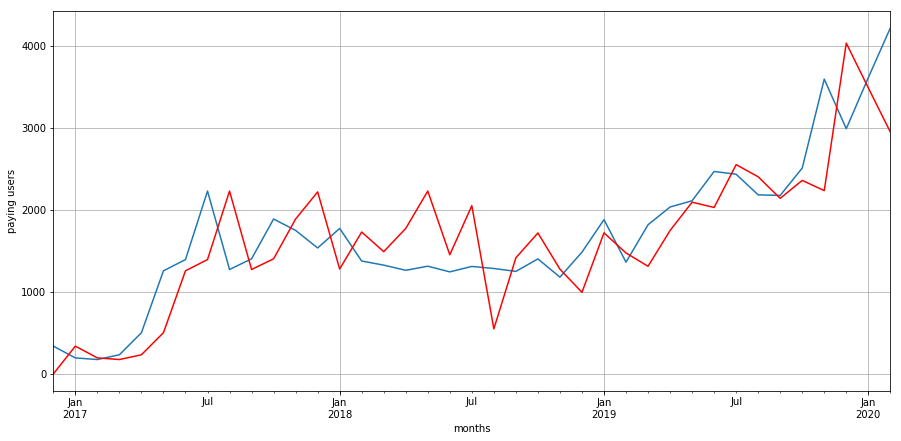

In [19]:
# Для начала посмотрим насколько прогноз модели совпадает с уже известными данными -
# видно, что прогноз не совсем точно описывает кривую ряда и рисует зигзаги,
# там где их нет, но исходнные данные имеют сложную ломаную структуру,
# в которой трудно найти закономерсности. В целом прогноз описывает исходные данные
pay_months['model'] = invboxcox(best_model.fittedvalues, lmbda=lmbda)
plt.figure(figsize=(15,7))
pay_months.hash.plot()
pay_months.model[:].plot(color='r')
plt.ylabel('paying users')
plt.grid()
plt.show()

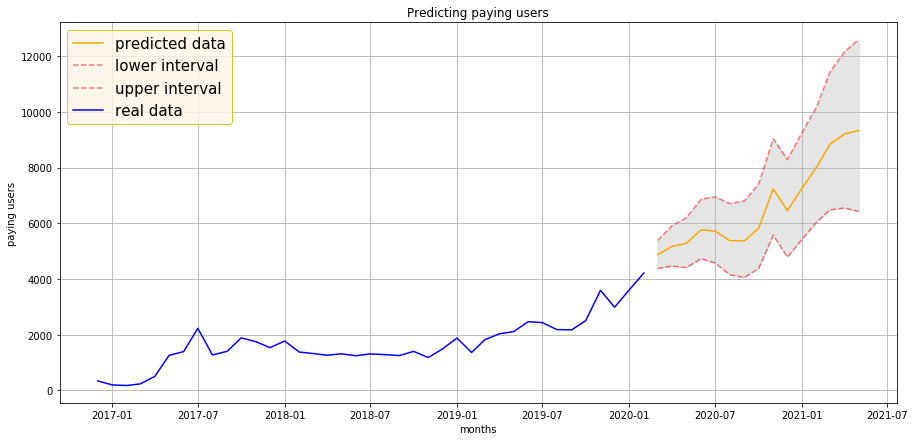

In [20]:
# Теперь сам прогноз - предсказание похоже на правду особенно с учетом трендов нескольких последних месяцев, 
# учтена некоторая сезонность.
forecast = best_model.get_forecast(steps=15)
plt.figure(figsize=(15,7))
plt.plot(np.round(invboxcox(forecast.predicted_mean, lmbda=lmbda)), color = "orange", label='predicted data')
intervals = forecast.conf_int(alpha=0.5)
intervals.columns=['lower interval', 'upper interval']
intervals['lower interval'] = invboxcox(intervals['lower interval'], lmbda=lmbda)
intervals['upper interval'] = invboxcox(intervals['upper interval'], lmbda=lmbda)
plt.plot(intervals['lower interval'], "r--", alpha=0.5)
plt.plot(intervals['upper interval'], "r--", alpha=0.5)
plt.fill_between(x=intervals.index, y1=intervals['upper interval'], 
                         y2=intervals['lower interval'], alpha=0.2, color = "grey")  
plt.plot(pay_months.hash, color = "blue", label='real data')
plt.ylabel('paying users')
plt.xlabel('months')
plt.legend(fontsize = 15,
          ncol = 1,
          facecolor = 'oldlace',
          edgecolor = 'y',
          title_fontsize = '20')
plt.grid()
plt.title('Predicting paying users')
plt.show()